Let's go.

In [39]:
import pandas as pd

In [40]:
def openData():
    df=pd.read_csv("../data.csv")
    df.drop_duplicates()
    return df
house=openData()
house.info()
house=house.drop(['district','test'],axis=1)
house=house.dropna(subset=['price'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   meter                 5186 non-null   int64  
 1   district              5186 non-null   object 
 2   buildYear             5186 non-null   int64  
 3   rooms                 5186 non-null   int64  
 4   price                 5186 non-null   int64  
 5   elevator              5186 non-null   int64  
 6   space                 5186 non-null   int64  
 7   parking               5186 non-null   int64  
 8   floor                 5186 non-null   int64  
 9   averageDistrictValue  5186 non-null   float64
 10  test                  5186 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 445.8+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [41]:
print(house.describe())

               meter     buildYear        rooms         price     elevator  \
count    5186.000000   5186.000000  5186.000000  5.186000e+03  5186.000000   
mean      183.359429   1394.533166     1.897609  1.153036e+10     0.731778   
std      4172.625938    173.926991     0.756410  1.672674e+10     0.443077   
min        19.000000   1370.000000     0.000000  0.000000e+00     0.000000   
25%        59.000000   1385.000000     1.000000  3.270000e+09     0.000000   
50%        80.000000   1393.000000     2.000000  6.000000e+09     1.000000   
75%       114.000000   1400.000000     2.000000  1.300000e+10     1.000000   
max    270000.000000  13902.000000     4.000000  2.400000e+11     1.000000   

             space      parking        floor  averageDistrictValue  
count  5186.000000  5186.000000  5186.000000          5.186000e+03  
mean      0.762630     0.858851     3.012341          9.906873e+07  
std       0.425512     0.348209     2.359462          5.894089e+07  
min       0.000000   

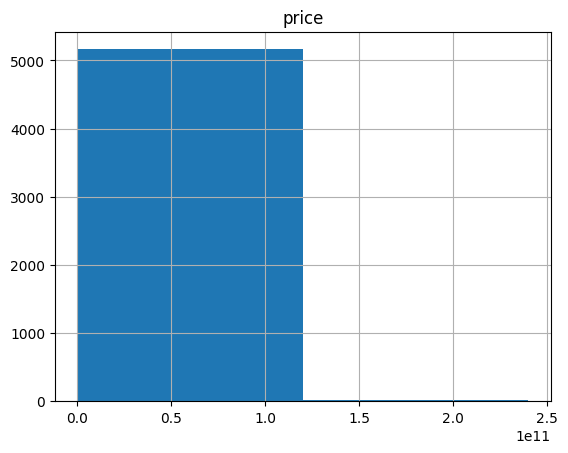

In [42]:
import matplotlib.pyplot as plt
house.hist(bins=50, figsize=(12, 8))
plt.show()

**making the test set**

In [43]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [44]:
house_with_id = house.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

count      5186.000000
mean        183.359429
std        4172.625938
min          19.000000
25%          59.000000
50%          80.000000
75%         114.000000
max      270000.000000
Name: meter, dtype: float64


Text(0, 0.5, 'Number of districts')

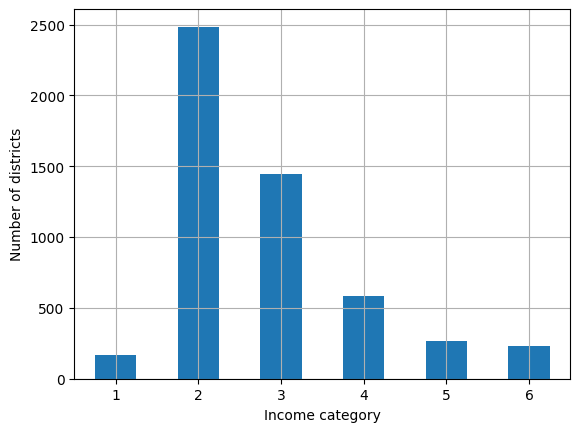

In [45]:
print(house['meter'].describe())
house["meter_cat"] = pd.cut(house["meter"].astype(float),
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
house["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(house, house["meter_cat"]):
    stratTrainSetN = house.iloc[trainIndex]
    stratTestSetN = house.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]

In [47]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_7751/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_7751/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [48]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price                   1.000000
averageDistrictValue    0.681139
rooms                   0.577906
space                   0.252272
elevator                0.250568
floor                   0.182835
parking                 0.163648
meter                   0.037880
buildYear              -0.000067
Name: price, dtype: float64


_note 1_ : wow it seems that meter is really important!

In [49]:

print(stratTrainSet.describe())
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet[['price']].copy()
print(labels.describe())

              meter     buildYear        rooms         price     elevator  \
count   4148.000000   4148.000000  4148.000000  4.148000e+03  4148.000000   
mean     140.707088   1395.115718     1.898987  1.152914e+10     0.733124   
std     2051.621360    194.427434     0.757038  1.674392e+10     0.442380   
min       19.000000   1370.000000     0.000000  0.000000e+00     0.000000   
25%       60.000000   1385.000000     1.000000  3.258750e+09     0.000000   
50%       80.000000   1393.000000     2.000000  6.000000e+09     1.000000   
75%      114.000000   1400.000000     2.000000  1.300000e+10     1.000000   
max    93500.000000  13902.000000     4.000000  2.400000e+11     1.000000   

             space      parking        floor  averageDistrictValue  
count  4148.000000  4148.000000  4148.000000          4.148000e+03  
mean      0.762295     0.859450     3.006991          9.908680e+07  
std       0.425729     0.347598     2.378304          5.894214e+07  
min       0.000000     0.00000

imputation

In [50]:
def imputeFrequent(cols,h):
    for col in cols:
        frequent = house[col].mode()
        h[[col]]=h[[col]].fillna(float(frequent),inplace=False)
    return h
house = imputeFrequent(['floor','rooms','meter','buildYear'], house)
house.describe()


,meter,buildYear,rooms,elevator,space,parking,floor,averageDistrictValue
count,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4.148000e+03
mean,140.707088,1395.115718,1.898987,0.733124,0.762295,0.859450,3.006991,9.908680e+07
std,2051.621360,194.427434,0.757038,0.442380,0.425729,0.347598,2.378304,5.894214e+07
min,19.000000,1370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.539284e+06
25%,60.000000,1385.000000,1.000000,0.000000,1.000000,1.000000,2.000000,5.723655e+07
50%,80.000000,1393.000000,2.000000,1.000000,1.000000,1.000000,3.000000,7.787802e+07
75%,114.000000,1400.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.292102e+08
max,93500.000000,13902.000000,4.000000,1.000000,1.000000,1.000000,30.000000,3.581995e+08


*Handling district*

number attributes:

In [51]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
houseNum=house.select_dtypes(np.number)
housingNumStd = std_scaler.fit_transform(houseNum)

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(house[["meter"]])

**And finally The PIPELINE**

In [52]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("standardize", StandardScaler()),
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"))

preprocessing = ColumnTransformer([
],remainder=num_pipeline)
housing_prepared = preprocessing.fit_transform(house)


**Train**

**Really, Really Testing for overfitting**

In [59]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())

forest_rmses = -cross_val_score(forest_reg, house, labels['price'],cv=10,scoring="neg_mean_squared_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [63]:
from math import sqrt
print(sqrt(forest_rmses.mean())/1e9,forest_rmses.std())

print(type(labels['price']))
forest_reg.fit(house,labels['price'])
housing_predictions = forest_reg.predict(house)
print(housing_predictions[:5]/1e9)
print(labels['price'][:5])


6.235518923337823 1.8516579769041932e+19
<class 'pandas.core.series.Series'>
[4.16114 6.53945 1.7767  2.1887  2.15212]
543     4200000000
2578    7100000000
4742     980000000
3995    2150000000
5054    2244000000
Name: price, dtype: int64
